# Neural Networks

In [912]:
import pandas as pd
import numpy as np
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.regularizers import l2

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [877]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

### Further split X_train and y_train to create validation sets for the Keras model

In [878]:
X_pure_train, X_val, y_pure_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.2)

### Divide the columns and define columns to drop

As before, we will drop unimportant columns. 

In [879]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [880]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

### Create the Column Transformer

We will log transform and scale integer columns, OHE categorical columns, and target endcode the geographical columns.

In [881]:
#Small function for the integer columns
def log_transform(x):
    return np.log(x+1)

In [882]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [883]:
#Fit_transform X_pure_train and y_pure_train; transform X_val and X_test (for later scoring the test set)
X_pure_train = transformer.fit_transform(X_pure_train, y_pure_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

### Pickle the Column Transformer

In [524]:
with open ('../Models/keras_transformer.pickle', 'wb') as f:
    pickle.dump(transformer, f, pickle.HIGHEST_PROTOCOL)

### OHE the target for use in the Keras model

In [884]:
ohe = OneHotEncoder(sparse=False)
y_pure_train_ohe = ohe.fit_transform(y_pure_train.values)
y_val_ohe = ohe.transform(y_val.values)

### keras0:  Build a simple neural network

In [929]:
#Create an EarlyStopping object that monitors 'val_f1_score' for a maximum, with a patience of five epochs.
early_stop = EarlyStopping(monitor='val_f1_score', mode='max', patience=5, verbose=1)

In [886]:
#Use the tensorflow add-on F1Score to create a micro averaged f1 score metric for the model
metric = tfa.metrics.F1Score(num_classes=3, average='micro')

In [887]:
keras0 = Sequential()
keras0.add(Dense(16, input_dim=X_pure_train.shape[1], activation='relu'))
keras0.add(Dense(8, activation='relu'))
keras0.add(Dense(3, activation='softmax'))

keras0.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=metric)

In [888]:
results = keras0.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 0s 3ms/step - loss: 0.9247 - f1_score: 0.5617 - val_loss: 0.7711 - val_f1_score: 0.6435
Epoch 2/50
157/157 [==============================] - 0s 2ms/step - loss: 0.6935 - f1_score: 0.6991 - val_loss: 0.6587 - val_f1_score: 0.7147
Epoch 3/50
157/157 [==============================] - 0s 2ms/step - loss: 0.6158 - f1_score: 0.7318 - val_loss: 0.6307 - val_f1_score: 0.7248
Epoch 4/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5923 - f1_score: 0.7401 - val_loss: 0.6239 - val_f1_score: 0.7277
Epoch 5/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5823 - f1_score: 0.7448 - val_loss: 0.6218 - val_f1_score: 0.7298
Epoch 6/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5781 - f1_score: 0.7464 - val_loss: 0.6215 - val_f1_score: 0.7310
Epoch 7/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5754 - f1_score: 0.7473 - val_loss: 0.6211 - val_f1_score: 0.7293
Epoch 

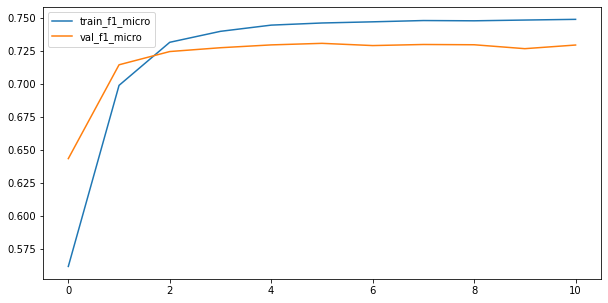

In [889]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [890]:
keras0_f1_micro = np.max(val_f1_micro)
keras0_f1_micro

0.7309797406196594

This is a baseline score, in the ballpark of our other models, though less than Random Forest, XGBoost, and SVM. It's also worth noting that the models validated f1-micro score level out after only two or three epochs.

### keras1: Add more layers to the neural network

In [891]:
keras1 = Sequential()
keras1.add(Dense(64, input_dim=X_pure_train.shape[1], activation='relu'))
keras1.add(Dense(32, activation='relu'))
keras1.add(Dense(16, activation='relu'))
keras1.add(Dense(8, activation='relu'))
keras1.add(Dense(3, activation='softmax'))

keras1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [892]:
results = keras1.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 1s 4ms/step - loss: 0.7273 - f1_score: 0.6829 - val_loss: 0.6273 - val_f1_score: 0.7250
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 0.5820 - f1_score: 0.7429 - val_loss: 0.6169 - val_f1_score: 0.7287
Epoch 3/50
157/157 [==============================] - 1s 3ms/step - loss: 0.5720 - f1_score: 0.7459 - val_loss: 0.6167 - val_f1_score: 0.7303
Epoch 4/50
157/157 [==============================] - 1s 6ms/step - loss: 0.5676 - f1_score: 0.7477 - val_loss: 0.6156 - val_f1_score: 0.7289
Epoch 5/50
157/157 [==============================] - 0s 3ms/step - loss: 0.5658 - f1_score: 0.7490 - val_loss: 0.6134 - val_f1_score: 0.7304
Epoch 6/50
157/157 [==============================] - 0s 3ms/step - loss: 0.5645 - f1_score: 0.7492 - val_loss: 0.6138 - val_f1_score: 0.7303
Epoch 7/50
157/157 [==============================] - 0s 3ms/step - loss: 0.5630 - f1_score: 0.7496 - val_loss: 0.6133 - val_f1_score: 0.7303
Epoch 

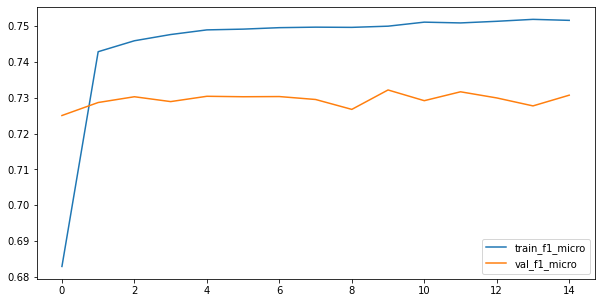

In [893]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [894]:
keras1_f1_micro = np.max(val_f1_micro)
keras1_f1_micro

0.7321821451187134

Addtional layers has improved the score slightly.  

### keras2: Add even more layers to the neural network

In [895]:
keras2 = Sequential()
keras2.add(Dense(512, input_dim=X_pure_train.shape[1], activation='relu'))
keras2.add(Dense(256, activation='relu'))
keras2.add(Dense(128, activation='relu'))
keras2.add(Dense(64, activation='relu'))
keras2.add(Dense(32, activation='relu'))
keras2.add(Dense(16, activation='relu'))
keras2.add(Dense(8, activation='relu'))
keras2.add(Dense(3, activation='softmax'))

keras2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [896]:
results = keras2.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 3s 18ms/step - loss: 0.6464 - f1_score: 0.7088 - val_loss: 0.6277 - val_f1_score: 0.7291
Epoch 2/50
157/157 [==============================] - 3s 17ms/step - loss: 0.5690 - f1_score: 0.7475 - val_loss: 0.6205 - val_f1_score: 0.7291
Epoch 3/50
157/157 [==============================] - 4s 23ms/step - loss: 0.5648 - f1_score: 0.7483 - val_loss: 0.6182 - val_f1_score: 0.7278
Epoch 4/50
157/157 [==============================] - 3s 18ms/step - loss: 0.5611 - f1_score: 0.7498 - val_loss: 0.6179 - val_f1_score: 0.7295
Epoch 5/50
157/157 [==============================] - 2s 15ms/step - loss: 0.5589 - f1_score: 0.7504 - val_loss: 0.6383 - val_f1_score: 0.7155
Epoch 6/50
157/157 [==============================] - 2s 16ms/step - loss: 0.5588 - f1_score: 0.7504 - val_loss: 0.6133 - val_f1_score: 0.7298
Epoch 7/50
157/157 [==============================] - 3s 20ms/step - loss: 0.5573 - f1_score: 0.7507 - val_loss: 0.6103 - val_f1_score: 0.7304

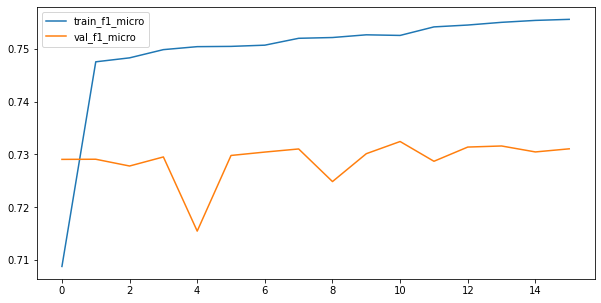

In [897]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [898]:
keras2_f1_micro = np.max(val_f1_micro)
keras2_f1_micro

0.7324380278587341

The addional complexity increases the score only marginally.  Let's still consider keras1 the better model, due to its relative simplicity.

### keras3:  Try using SMOTE

First, I'll resample X_pure_train (to which the Column Transformer was already applied) and y_pure train using SMOTE. Then I'll OHE the new resampled y_pure_train in addition to transforming y_val again with the fitted OHE. I'll use the model structure of keras1, since it's a simpler model than keras2, but produced a similar validated f1-micro score. 

In [899]:
smote = SMOTE()
X_pure_train_resampled, y_pure_train_resampled = smote.fit_sample(X_pure_train, y_pure_train)

In [902]:
ohe = OneHotEncoder(sparse=False)
y_pure_train_resampled_ohe = ohe.fit_transform(y_pure_train_resampled.values)
y_val_ohe = ohe.transform(y_val.values)

In [906]:
keras3 = Sequential()
keras3.add(Dense(64, input_dim=X_pure_train_resampled.shape[1], activation='relu'))
keras3.add(Dense(32, activation='relu'))
keras3.add(Dense(16, activation='relu'))
keras3.add(Dense(8, activation='relu'))
keras3.add(Dense(3, activation='softmax'))

keras3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [907]:
results = keras3.fit(X_pure_train_resampled, y_pure_train_resampled_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
267/267 [==============================] - 1s 3ms/step - loss: 0.6771 - f1_score: 0.6934 - val_loss: 0.7204 - val_f1_score: 0.6806
Epoch 2/50
267/267 [==============================] - 1s 3ms/step - loss: 0.5708 - f1_score: 0.7563 - val_loss: 0.7286 - val_f1_score: 0.6779
Epoch 3/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5633 - f1_score: 0.7598 - val_loss: 0.7176 - val_f1_score: 0.6850
Epoch 4/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5602 - f1_score: 0.7609 - val_loss: 0.7151 - val_f1_score: 0.6798
Epoch 5/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5570 - f1_score: 0.7617 - val_loss: 0.7239 - val_f1_score: 0.6775
Epoch 6/50
267/267 [==============================] - 1s 3ms/step - loss: 0.5544 - f1_score: 0.7630 - val_loss: 0.7230 - val_f1_score: 0.6853
Epoch 7/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5530 - f1_score: 0.7630 - val_loss: 0.7220 - val_f1_score: 0.6805
Epoch 

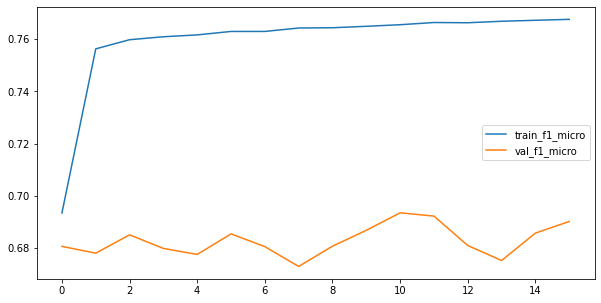

In [908]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [909]:
keras3_f1_micro = np.max(val_f1_micro)
keras3_f1_micro

0.6934254169464111

Using SMOTE results in an inferior validated f1-micro score.  Keras1 is still the best model.

### keras4:  Try using regularization

Again, we will use keras1 as the baseline and then add some regularization to the layers.

In [917]:
keras4 = Sequential()
keras4.add(Dense(64, input_dim=X_pure_train.shape[1], activation='relu'))
keras4.add(Dense(32, activation='relu', kernel_regularizer=l2(l2=.001)))
keras4.add(Dense(16, activation='relu', kernel_regularizer=l2(l2=.001)))
keras4.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=.001)))
keras4.add(Dense(3, activation='softmax'))

keras4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [918]:
results = keras4.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 1s 4ms/step - loss: 0.8717 - f1_score: 0.6511 - val_loss: 0.7090 - val_f1_score: 0.7135
Epoch 2/50
157/157 [==============================] - 0s 3ms/step - loss: 0.6475 - f1_score: 0.7381 - val_loss: 0.6808 - val_f1_score: 0.7277
Epoch 3/50
157/157 [==============================] - 0s 3ms/step - loss: 0.6252 - f1_score: 0.7454 - val_loss: 0.6692 - val_f1_score: 0.7282
Epoch 4/50
157/157 [==============================] - 0s 3ms/step - loss: 0.6173 - f1_score: 0.7469 - val_loss: 0.6653 - val_f1_score: 0.7277
Epoch 5/50
157/157 [==============================] - 0s 3ms/step - loss: 0.6117 - f1_score: 0.7473 - val_loss: 0.6590 - val_f1_score: 0.7283
Epoch 6/50
157/157 [==============================] - 0s 3ms/step - loss: 0.6069 - f1_score: 0.7478 - val_loss: 0.6588 - val_f1_score: 0.7263
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 0.6037 - f1_score: 0.7477 - val_loss: 0.6520 - val_f1_score: 0.7278
Epoch 

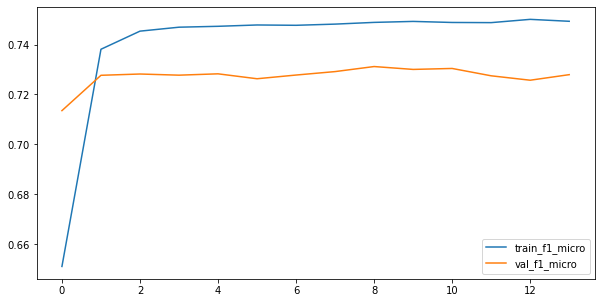

In [919]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [920]:
keras4_f1_micro = np.max(val_f1_micro)
keras4_f1_micro

0.7311844229698181

Regularization reduces the f1-micro score slightly, though it is close to keras1.  We'll finish here and say that keras1 is the best model.

In [930]:
print(f'keras0_f1_micro: {round(keras0_f1_micro, 4)}')
print(f'keras1_f1_micro: {round(keras1_f1_micro, 4)}')
print(f'keras2_f1_micro: {round(keras2_f1_micro, 4)}')
print(f'keras3_f1_micro: {round(keras3_f1_micro, 4)}')
print(f'keras4_f1_micro: {round(keras4_f1_micro, 4)}')

keras0_f1_micro: 0.731
keras1_f1_micro: 0.7322
keras2_f1_micro: 0.7324
keras3_f1_micro: 0.6934
keras4_f1_micro: 0.7312


### Make predictions on the test set using keras1 and calculate the f1-micro score

In [924]:
y_hat_test = np.argmax(keras1.predict(X_test), axis=-1)

In [925]:
f1_score(y_test, y_hat_test + 1, average='micro')

0.7299964697395281

### Check model's target accuracies

In [927]:
cm = confusion_matrix(y_test, y_hat_test + 1)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 54.5% of low damage.
The model correctly predicts 82.4% of medium damage.
The model correctly predicts 62.35% of complete destruction.


### Export the model

In [928]:
keras1.save('../Models/keras1')

INFO:tensorflow:Assets written to: ../Models/keras1/assets
